In [1]:
from kitti_detection import config
from kitti_detection.dataset import DataSample, class_names, class_counts, load_train_val_test_dataset
from kitti_detection.utils import display_samples_h

import torch
from torch import nn, optim, Tensor
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes
from torchvision.ops.roi_pool import RoIPool
from torchvision.models import vgg16, VGG16_Weights
from torchvision.ops import box_iou

import cv2
import numpy as np
import math
import random
import time


from typing import Optional

# Overview

In [2]:
torch.autograd.set_detect_anomaly(True)
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu") 

print(DEVICE)

cuda


In [5]:
torch.__version__

'2.3.0+cu121'

In [6]:
transforms = v2.Compose([
    v2.RandomCrop(size=(370, 370)),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.Resize((224, 224)),
    v2.ToTensor(),  # Convert PIL Image to Tensor
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  # Normalize to [0, 1]
    v2.SanitizeBoundingBoxes(min_size=15.0)
])

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
train_dataset, val_dataset, test_dataset = load_train_val_test_dataset()

train_dataset.transform = transforms
val_dataset.transform = transforms

/data/image/train


In [8]:
n_classes = len(class_names)

In [9]:
data_loader = DataLoader(train_dataset, batch_size=None, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=None, shuffle=True)

<class 'list'>
[tensor([[[-1.4843, -1.4672, -1.3473,  ..., -0.4911, -0.4911, -0.5253],
         [-1.5014, -1.5014, -1.4329,  ..., -0.4054, -0.4397, -0.5082],
         [-1.5014, -1.5014, -1.4672,  ..., -0.4568, -0.4568, -0.4739],
         ...,
         [-1.3644, -1.3987, -1.4158,  ..., -1.8953, -1.8782, -1.8782],
         [-1.2788, -1.2959, -1.3644,  ..., -1.8610, -1.8439, -1.8268],
         [-1.3473, -1.3473, -1.3302,  ..., -1.8610, -1.8439, -1.8268]],

        [[-1.2129, -1.2129, -1.5105,  ..., -0.3725, -0.3725, -0.3901],
         [-1.2654, -1.2654, -1.4405,  ..., -0.3375, -0.3550, -0.3375],
         [-1.4405, -1.3529, -1.2829,  ..., -0.3725, -0.3901, -0.3725],
         ...,
         [-1.2479, -1.2479, -1.2479,  ..., -1.7031, -1.7031, -1.7031],
         [-1.1954, -1.1779, -1.1954,  ..., -1.7031, -1.7031, -1.6681],
         [-1.1253, -1.1779, -1.1779,  ..., -1.7206, -1.7031, -1.7031]],

        [[-1.3513, -1.3861, -1.4384,  ..., -0.0267, -0.0964, -0.1138],
         [-1.4733, -1.5081, -

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


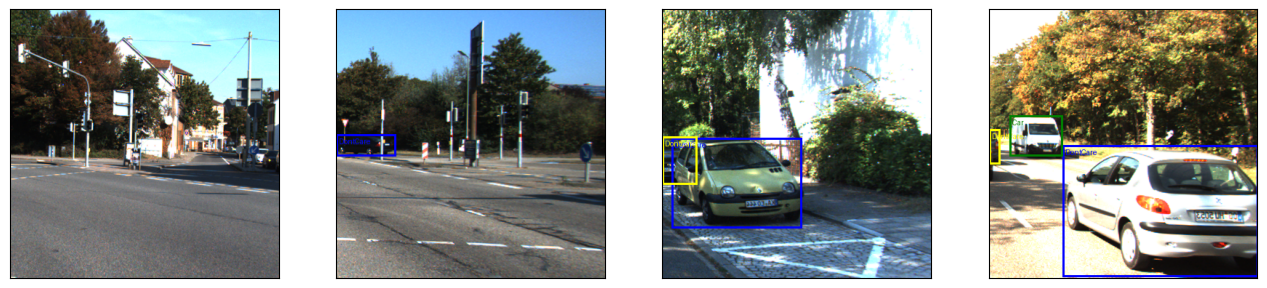

In [10]:
elements = next(iter(data_loader))
print(type(elements))
print(elements)
display_samples_h([next(iter(data_loader)) for _ in range(4)])

**VGG16**
<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ">

# Model

In [11]:
def new_forward(model, x: torch.Tensor) -> torch.Tensor:
        x = model.features(x)
        # Skipping the flattening, the average pooling and the original classifier
        return x

In [12]:
def convert_rois(rois: torch.Tensor) -> torch.Tensor:
    # Create a tensor of zeros with shape [64, 1]
    zeros_column = torch.zeros(64, 1, device=DEVICE)


    # Adding a column full of zeros as first column since RoI Pool needs the id of the picture in the batch (works for batch size 1)
    final_rois = torch.cat((zeros_column, rois), dim=1)
    return final_rois

In [13]:
def check_for_nans(module, input, output):
    if torch.isnan(output).any():
        raise ValueError(f"NaN values detected in output of {module}")

def print_grad(module, grad_input, grad_output):
    print(f"Gradient of module {module}:")
    print('input')
    print(grad_input)
    print('output')
    print(grad_output)

    
def register_hooks(model):
    for layer in model.children():
        layer.register_forward_hook(check_for_nans)
        layer.register_forward_hook(print_grad)


In [14]:
class FastRCNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.dropout=0.5

        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=23/370) # Input: 224 * 224 | roi input: 14 * 14 -> 14/224 = 0.0625
        self.conv = self._prepare_vgg16()
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),
            nn.LayerNorm([4096]),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout),
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.LayerNorm([4096]),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=n_classes + 1)
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.LayerNorm([4096]),
            nn.ReLU(True),
            nn.Linear(in_features=4096, out_features=4)
        )

        #register_hooks(self)

    def _prepare_vgg16(self, weights: Optional[VGG16_Weights] = None) -> nn.Module:
        vgg16 = models.vgg16(weights)
        #vgg16 = vgg16.to(DEVICE)

        # Replace the existing forward method
        vgg16.forward = lambda x: new_forward(vgg16, x)

        vgg16.features[-1] = nn.Identity()
        vgg16.avgpool = nn.Identity()
        vgg16.classifier = nn.Identity()

        return vgg16

    def forward(self, x):
        # Model input: tuple of 1. single image tensor 2. BoundingBoxes tensor of region proposal ROIs

        #if isinstance(x, tuple) and len(x) == 2:
        #    if not isinstance(x[0], Tensor):
        #        raise TypeError("Expected the first element of the tuple to be a torch.Tensor")
        #    if not isinstance(x[1], list):
        #        raise TypeError("Expected the second element of the tuple to be a list (of BoundingBoxes)")
        #else:
        #    raise TypeError("Expected a tuple containing (Tensor, BoundingBoxes)")

        img, rois = x
        
        rois = convert_rois(rois)
        

        #print(f'Max value image: {torch.max(img)}')
        #print(img)
        #assert not torch.isnan(img).any(), "Input contains NaN values"

        fmap = self.conv(img)

        #print(f'Max value fmap: {torch.max(fmap)}')
        #print(f'input - Max value rois: {torch.max(rois)}')
        #print('Feature map')
        #print(fmap)
        #if torch.isnan(fmap).any():
        #    nan_indices = torch.isnan(fmap)
        #    fmap[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('fmap HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(fmap)
        #    raise ValueError("NaNs found in fmap")
        #print(f'FMAP shape: {fmap.shape}')
        # Shape if [1, 512, 7, 7]
        #rois = rois.to(DEVICE)
        #print(f'shape of rois: {rois.shape}')
        # Shape is [64, 5]


        windows = self.roi_pool(fmap, rois=rois)

        #print('ROIS:')
        #print(rois)
        #print(f'Max value windows1: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows1 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #    raise ValueError("NaNs found in windows")
        #print(f'shape of output of roi pool: {windows.shape}')
        # Shape is [64, 512, 7, 7]
        #return None, None
        #assert not torch.isnan(windows).any(), "Input contains NaN values"
        #print(f'flatten: {windows}')
        #print(f'shape of flatten: {windows.shape}')
        #print(f'type of flatten: {type(windows)}')
        #windows_cpu = windows.cpu()
        #print(windows_cpu.device)

        windows = torch.flatten(windows, start_dim=1)

        #print('Windows2')
        #print(f'Max value windows2: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows2 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #    raise ValueError("NaNs found in windows")
        #print(f'shape after flatten: {windows.shape}')
        # Shape is [64, 25088]

        windows = self.fc(windows)

        #print('Windows3')
        #print(f'Max value windows3: {torch.max(windows)}')
        #print(windows)
        #if torch.isnan(windows).any():
        #    nan_indices = torch.isnan(windows)
        #    windows[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('windows3 HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(windows)
        #    raise ValueError("NaNs found in windows3")
        #print(f'shape after fc: {windows.shape}')
        # Shape is [64, 4096]
        #assert not torch.isnan(windows).any(), "Input contains NaN values"

        pred_classes = self.classifier(windows)

        #print('pred_classes')
        #print(pred_classes)
        #if torch.isnan(pred_classes).any():
        #    nan_indices = torch.isnan(pred_classes)
        #    pred_classes[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('pred_classes HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(pred_classes)
        #    raise ValueError("NaNs found in pred_classes")
        #print(f'shape of pred_classes: {pred_classes.shape}')
        # Shape is [64, 10]

        pred_bboxes = self.bbox_regressor(windows)

        #print('pred_bboxes')
        #print(pred_bboxes)
        #if torch.isnan(pred_bboxes).any():
        #    nan_indices = torch.isnan(pred_bboxes)
        #    pred_bboxes[nan_indices] = 0.0001  # Replace NaN values with 0.0001
        #    print('pred_bboxes HAS NAN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        #    print(pred_bboxes)
        #    raise ValueError("NaNs found in pred_bboxes")

        #print(f'shape after pred_bboxes: {pred_bboxes.shape}')
        # Shape is [64, 4]

        return pred_classes, pred_bboxes

# Class weights

In [15]:
# Calculating class weights
"""
class_counts = dict.fromkeys(class_names, 0)

for idx, sample in enumerate(data_loader):
    for class_id in sample[1].get('labels'):
        class_counts[class_names[class_id]] = class_counts[class_names[class_id]] + 1
"""
# Calculating weights as inverse ratio of count
# Also since we will add
print(f'Class counts: {class_counts}')
classification_weights = class_counts.copy()
n_objects = sum(list(class_counts.values()))
print(n_objects)
for object_class in class_counts.keys():
    classification_weights[object_class] = (1 - (class_counts.get(object_class) / n_objects))

print(classification_weights)
classification_weights = torch.tensor(list(classification_weights.values()), dtype=torch.float32)
# Adding 1.0 weight for the Background object --> Must scale down --> Not here. Depends on the small/big iou ratio
classification_weights = torch.cat([torch.tensor([1.0]), classification_weights], dim=0)
print(classification_weights)
classification_weights = classification_weights.to(DEVICE)

Class counts: {'Car': 8297, 'Van': 881, 'Truck': 343, 'Pedestrian': 1034, 'Person_sitting': 44, 'Cyclist': 374, 'Tram': 140, 'Misc': 251, 'DontCare': 0}
11364
{'Car': 0.2698873636043646, 'Van': 0.9224744808166139, 'Truck': 0.9698169658570925, 'Pedestrian': 0.9090109116508271, 'Person_sitting': 0.9961281239000352, 'Cyclist': 0.9670890531502991, 'Tram': 0.9876803942273847, 'Misc': 0.9779127067933826, 'DontCare': 1.0}
tensor([1.0000, 0.2699, 0.9225, 0.9698, 0.9090, 0.9961, 0.9671, 0.9877, 0.9779,
        1.0000])


# Generating proposals

In [16]:
TRAIN_ROI_PROPOSALS = 64
BIG_IOU_THRESHOLD = 0.25

In [17]:
def restore_encoding(tensor: torch.Tensor) -> torch.Tensor:
    new_tensor = torch.Tensor().to(DEVICE)
    for element in tensor:
        if element == 0:
          element = element +1
        new_row = torch.tensor(element-1).unsqueeze(0)
        new_row = new_row.to(DEVICE)
        new_tensor = torch.cat([new_tensor, new_row], dim=0)

    new_tensor = new_tensor.to(dtype=torch.int32, device=DEVICE)

    return new_tensor

In [18]:
def convert_tensor_to_cv2(tensor: Tensor) -> np.array:
    numpy_image = tensor.numpy(force=True) # force=True if on GPU
    # Detaches tensor and returns numpy

    # CHW -> HWC
    cv2_image = np.transpose(numpy_image, (1, 2, 0))

    # Convert color space: RGB -> BGR
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_RGB2BGR)

    return cv2_image

def generate_roi_proposals(img) -> BoundingBoxes:
    # Convert image from tensor to opencv format.
    cv2_image = convert_tensor_to_cv2(img)

    start_ss = time.time()

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(cv2_image)
    ss.switchToSelectiveSearchFast() #Other option is fast, but less accurate
    rects = ss.process() # rects is a np array containing [x, y, w, h] numpy arrays
    end_ss = time.time()
    duration_ss = end_ss - start_ss
    #print(f'Duration of ss: {duration_ss} seconds')

    #print(f'Number of generated RoIs is: {len(rects)}')

    boxes = [(float(rect[0]), float(rect[1]), float(rect[0]+rect[2]), float(rect[1]+rect[3])) for rect in rects] # convert to the consistent XYXY format
    boxes = BoundingBoxes(boxes, format='XYXY', canvas_size=v2.functional.get_size(img))
    boxes = boxes.to(DEVICE) 

    return boxes

In [19]:
def getIoUProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    max_n_real_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    # Getting the max IoU for every RoI
    max_ious, gt_indices = ious.max(dim=1)

    # Getting the number of real RoI-s 
    num_gte_real_threshold = (max_ious >= 0.5).sum().item()
    
    # Getting the number of background RoIs
    n_real_proposals = min(max_n_real_proposals, num_gte_real_threshold)
    n_background_proposals = TRAIN_ROI_PROPOSALS - n_real_proposals

    # Sorting the values and getting the indices
    sorted_indices_for_iou_value = torch.argsort(max_ious, descending=True)

    real_indices_for_iou_value = sorted_indices_for_iou_value[:n_real_proposals]
    background_indices_for_iou_value = sorted_indices_for_iou_value[num_gte_real_threshold : num_gte_real_threshold + n_background_proposals]

    real_rois = roi_proposals[real_indices_for_iou_value]
    background_rois = roi_proposals[background_indices_for_iou_value]

    real_gts = gt_indices[real_indices_for_iou_value]

    # Dont need since these will be considered background
    background_gts = gt_indices[background_indices_for_iou_value]

    # Returns the RoIs with more than 0.5 IoU (max 16) --> shape [n_real_proposals, 4]
    # Returns the RoIs woth less then 0.5 IoU (max 64 - ...) --> shape [n_background_proposals, 4]
    # Returns the indices of the ground truth corresponding to the real RoIs (So which one is the corresponding object on the picture)
    return real_rois, background_rois, real_gts, background_gts

In [20]:
"""
def getBigIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)

    max_ious, gt_indices = ious.max(dim=1) # Get the max value each row (so for each proposal see if there is a gt that has >= 0.5 IoU with) also the column index where the max value was. Since each column is a gt, we get the index of the gt it has big IoU with
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[max_ious >= 0.5] # Filter rows/proposals where there is a gt that has >= 0.5 IoU with
    valid_ious = max_ious[max_ious >= 0.5] # The IoU value for each proposals that has >= IoU with a gt
    valid_gt_indices = gt_indices[max_ious >= 0.5]

    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices] # Sort proposals by the IoU values
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]

    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]

    #print('Big proposals')
    #print(top_proposals)

    return top_proposals, top_gt_indices


def getSmallIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor, big_iou_proposals: int) -> tuple[torch.Tensor, torch.Tensor]:
    # Max number of proposals to select
    max_n_proposals = TRAIN_ROI_PROPOSALS - big_iou_proposals

    max_ious, gt_indices = ious.max(dim=1)
    # Sort only those proposals, where the max IoU is greater than the threshold
    valid_proposals = roi_proposals[(max_ious < 0.5)]
    valid_ious = max_ious[(max_ious < 0.5)]
    valid_gt_indices = gt_indices[(max_ious < 0.5)]


    # Sort the valid proposals by IoU in descending order
    sorted_indices = torch.argsort(valid_ious, descending=True)
    sorted_proposals = valid_proposals[sorted_indices]
    sorted_ious = valid_ious[sorted_indices]
    sorted_gt_indices = valid_gt_indices[sorted_indices]


    top_proposals = sorted_proposals[:max_n_proposals] # Tensor of tensors
    top_ious = sorted_ious[:max_n_proposals]
    top_gt_indices= sorted_gt_indices[:max_n_proposals]


    #print('Small proposals')
    #print(top_proposals)


    return top_proposals, top_gt_indices
    """


"\ndef getBigIouProposals(ious: torch.Tensor, roi_proposals: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:\n    # Max number of proposals to select\n    max_n_proposals = int(TRAIN_ROI_PROPOSALS * BIG_IOU_THRESHOLD)\n\n    max_ious, gt_indices = ious.max(dim=1) # Get the max value each row (so for each proposal see if there is a gt that has >= 0.5 IoU with) also the column index where the max value was. Since each column is a gt, we get the index of the gt it has big IoU with\n    # Sort only those proposals, where the max IoU is greater than the threshold\n    valid_proposals = roi_proposals[max_ious >= 0.5] # Filter rows/proposals where there is a gt that has >= 0.5 IoU with\n    valid_ious = max_ious[max_ious >= 0.5] # The IoU value for each proposals that has >= IoU with a gt\n    valid_gt_indices = gt_indices[max_ious >= 0.5]\n\n    # Sort the valid proposals by IoU in descending order\n    sorted_indices = torch.argsort(valid_ious, descending=True)\n    sorted_proposals = v

In [21]:
def calculate_target_bbox_correction(roi_bboxes: BoundingBoxes, gt_bboxes: BoundingBoxes) -> torch.Tensor:

    assert roi_bboxes.shape[0] == gt_bboxes.shape[0]
    correction_vectors = torch.Tensor().to(DEVICE)

    for i in range(roi_bboxes.shape[0]):
        gx, gy, gx2, gy2 = gt_bboxes[i]
        gw = gx + gx2
        gh = gy + gy2

        px, py, px2, py2 = roi_bboxes[i]
        pw = px + px2
        ph = py + py2

        tx = (gx - px) / pw
        ty = (gy - py) / ph
        tw = torch.log(gw / pw)
        th = torch.log(gh / ph)
        transform_tensor = torch.Tensor((tx, ty, tw, th)).unsqueeze(0)
        transform_tensor = transform_tensor.to(DEVICE)

        correction_vectors = torch.cat([correction_vectors, transform_tensor], dim=0)
        correction_vectors = correction_vectors.to(DEVICE)

    return correction_vectors

In [22]:
def get_target_classes(labels: torch.Tensor, gt_indices: torch.Tensor) -> torch.Tensor:
    gt_target_labels = torch.Tensor().to(device=DEVICE)
    
    for idx in gt_indices:
        # Adding one to so 0 is background
        class_id = labels[idx] + 1

        # Concatenate the existing tensor with the new element
        gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)

    gt_target_labels = gt_target_labels.to(dtype=torch.int32)

    #print('TARGET CLASSES DEFINED:')
    #print(gt_target_labels)

    return gt_target_labels

In [23]:
def generate_training_samples(ground_truth: DataSample) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # input: DataSample containing image and ground truth labels
    # output: tuple of 1. ROI proposals 2. target classes 3. target bounding box corrections
    #         ROI proposals should be a List[Tensor] where the Tensore's shape is (1,4)
    #         each are tensors of shape (TRAINING_ROI_PROPOSALS, ...)
    img = ground_truth[0]
    boxes = ground_truth[1].get('boxes')
    labels = ground_truth[1].get('labels')

    if not boxes.shape[0]:
        # There are no objects on the picture 
        return None, None, None
    
    img = img.to(DEVICE)
    boxes = boxes.to(DEVICE)
    labels = labels.to(DEVICE)
    #print(f'generate img device: {img.device}')
    

    before_roi = time.time()
    roi_proposals = generate_roi_proposals(img)
    after_roi = time.time()
    duration_roi = after_roi - before_roi
    #print(f'Duration roi: {duration_roi} seconds')
    #print(f'generate roi_proposals device: {roi_proposals.device}')    

    # Get the IoU of proposals and ground thruthes
    # The returned shape of tensor is [n_proposals, n_gt]   
    before_ious = time.time() 
    ious = box_iou(roi_proposals, boxes)
    after_ious = time.time()
    duration_ious = after_ious - before_ious
    #print(f'Duration ious: {duration_ious} seconds')
    
    #print(f'generate ious device: {ious.device}')
    #print('Ious between proposals and ground truth')
    #print(ious)

    before_gen = time.time()
    real_roi_proposals, background_roi_proposals, real_gts, background_gts  = getIoUProposals(ious, roi_proposals)
    after_gen = time.time()
    duration_gen = after_gen - before_gen
    #print(f'Duration gen: {duration_gen} seconds')

    if real_roi_proposals.nelement() == 0:
       return None, None, None 

    before_other = time.time()
    # Concat the roi proposals
    roi_proposals = torch.cat([real_roi_proposals, background_roi_proposals], dim=0)

    # Get the target classes
    real_target_classes = get_target_classes(labels, real_gts)
    background_target_classes = torch.zeros(background_roi_proposals.shape[0], dtype=torch.int32, device=DEVICE)

    target_classes = torch.cat([real_target_classes, background_target_classes], dim=0)
    if target_classes.sum() == 0:
      i = 1
      i += 1 

    # Calculate the bounding box corrections. Only for the real bboxes, the others are not calculated in the loss
    if not real_gts.nelement() == 0:
      real_gt_bboxes_for_rois = [boxes[idx] for idx in real_gts]
      real_gt_bboxes_for_rois = torch.stack(real_gt_bboxes_for_rois)
      real_gt_bboxes_for_rois = real_gt_bboxes_for_rois.to(DEVICE)
    else:
       real_gt_bboxes_for_rois = torch.Tensor().to(device=DEVICE)

    if not background_gts.nelement() == 0:
      background_gt_bboxes_for_rois = [boxes[idx] for idx in background_gts]
      background_gt_bboxes_for_rois = torch.stack(background_gt_bboxes_for_rois)
      background_gt_bboxes_for_rois = background_gt_bboxes_for_rois.to(DEVICE)
    else:
       background_gt_bboxes_for_rois = torch.Tensor().to(device=DEVICE)

    real_target_bbox_correction = calculate_target_bbox_correction(real_roi_proposals, real_gt_bboxes_for_rois)
    background_target_bbox_correction = calculate_target_bbox_correction(background_roi_proposals, background_gt_bboxes_for_rois)

    target_bbox_correction = torch.zeros(TRAIN_ROI_PROPOSALS, 4, device=DEVICE)

    if not real_target_classes.nelement() == 0:
      target_bbox_correction[:real_target_classes.shape[0], :] = real_target_bbox_correction
    target_bbox_correction[real_target_classes.shape[0]:, :] = background_target_bbox_correction


    if not real_roi_proposals.shape[0] + background_roi_proposals.shape[0] == TRAIN_ROI_PROPOSALS:
      print('THERE ARE NOT ENOUGH PROPOSALS, which is a big problem...')

    after_other = time.time()
    duration_other = after_other - before_other
    #print(f'Duration other: {duration_other} seconds')

    return roi_proposals, target_classes, target_bbox_correction

    """
    assert not torch.isnan(roi_proposals).any(), "roi proposals contains NaN values"
    assert not torch.isnan(target_classes).any(), "target classes contains NaN values"
    assert not torch.isnan(target_bbox_correction).any(), "target bbox correction contains NaN values"

    print("Roi proposals + target classes + bbox correction")
    print(roi_proposals)
    print(target_classes)
    print(target_bbox_correction)
    """

# Testing training

In [24]:
test_data_sample = next(iter(data_loader))
generate_training_samples(test_data_sample)

/tmp/ipykernel_150781/4115497863.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)


(tensor([[ 64., 163., 172., 203.],
         [  0., 166., 201., 213.],
         [  0., 168., 173., 213.],
         [  0., 166., 201., 209.],
         [ 54., 131., 172., 220.],
         [288., 181., 370., 329.],
         [288., 183., 370., 329.],
         [  0., 169., 189., 205.],
         [  0., 161., 189., 201.],
         [288., 183., 370., 332.],
         [ 54., 123., 172., 220.],
         [  0., 155., 189., 205.],
         [  0., 151., 201., 213.],
         [120., 166., 201., 209.],
         [141., 184., 259., 230.],
         [  0., 160., 173., 201.],
         [  0., 161., 168., 201.],
         [141., 174., 297., 230.],
         [  0., 155., 189., 201.],
         [ 68., 131., 172., 203.],
         [141., 173., 297., 230.],
         [  0., 168., 173., 201.],
         [141., 171., 298., 230.],
         [141., 170., 299., 230.],
         [142., 187., 256., 230.],
         [152., 184., 259., 226.],
         [132., 181., 200., 209.],
         [ 64., 163., 128., 203.],
         [ 68., 123.

# Loss calculation

In [25]:
# See 2.1 / Multi task loss

class MultiTaskLoss(nn.Module):

   def __init__(self, classification_weights = None, lmbd : Optional[float] = 1.0) -> None:
      super().__init__()
      self.classification_weights = classification_weights
      self.lmbd = lmbd


   def forward(self, input: tuple[torch.Tensor, torch.Tensor], target: tuple[torch.Tensor, torch.Tensor]):
      input_class, input_bbox = input
      target_class, target_bbox = target

      #input_class = input_class.to(DEVICE) 
      #input_bbox = input_bbox.to(DEVICE) 
      #target_class = target_class.to(DEVICE) 
      #target_bbox = target_bbox.to(DEVICE) 

      c = torch.where(target_class < 1, 0.0, 1.0)
      real_all_ratio = (c.sum() / TRAIN_ROI_PROPOSALS)
      c = c.unsqueeze(1)

      # Function contains softmax unit (acc. documentation "The input is expected to contain the unnormalized logits for each class")
      # Because of the unbalanced class distribution classification weight is recommended
      #print(f'Shape of input class: {input_class.shape}')
      # Shape is [64, 10]
      #print(f'Shape of target class: {target_class.shape}')
      # Shape is [64]

      target_class_clone = target_class.clone()
      target_class_clone = target_class_clone.type(torch.long)

      if not classification_weights == None:
         classification_weights_clone = classification_weights.clone()

         classification_weights_clone[0] = classification_weights_clone[0] * real_all_ratio
         for i in range(1, len(classification_weights_clone)):
            classification_weights_clone[i] = classification_weights_clone[i] * (1 - real_all_ratio)


      #print(f'loss input device: {input_class.device}')
      #print(f'loss target_class_clone device: {target_class_clone.device}')

      # The input contains NaN
      #if (torch.isnan(input_class).any()) | (torch.isnan(target_class_clone).any()):
         #i = 10

      #if torch.isnan(input_class).any() or torch.isnan(target_class_clone).any():
         #raise ValueError("NaN values detected in classification inputs")
      

      #if torch.isnan(input_class).any() or torch.isinf(input_class).any():
        #print("NaNs or Infs found in input_class")
        #print(input_class)
        #raise ValueError("NaNs or Infs found in input_class")

      # Check for NaNs or Infs in target_class_clone
      #if torch.isnan(target_class_clone).any() or torch.isinf(target_class_clone).any():
         #print("NaNs or Infs found in target_class_clone")
         #print(target_class_clone)
         #raise ValueError("NaNs or Infs found in target_class_clone")

      # Check the range of target_class_clone
      #if target_class_clone.min() < 0 or target_class_clone.max() >= 10:
         #print(f"Invalid class indices found in target_class_clone: {target_class_clone}")
         #raise ValueError("Invalid class indices in target_class_clone")

      # Print shapes and some statistics
      #print(f"input_class shape: {input_class.shape}")
      #print(f"target_class_clone shape: {target_class_clone.shape}")
      #print(f"input_class stats: min={input_class.min()}, max={input_class.max()}, mean={input_class.mean()}")
      #print(f"target_class_clone stats: min={target_class_clone.min()}, max={target_class_clone.max()}, mean={target_class_clone.float().mean()}")

      #print(f"input_class: {input_class}")
      #print(f"target_class_clone: {target_class_clone}")
      #print(f"classification_weights_clone: {classification_weights_clone}")

      cls_loss = nn.functional.cross_entropy(input_class, target_class_clone, weight=classification_weights_clone)
      #print(f'Cross entropy loss: {cls_loss}')

      if math.isnan(cls_loss):
         i = 10

      #print(f'Cross entropy loss: {cls_loss}')

      

      #print('C is:')
      #print(c)
      #print(c.shape)

      smooth_loss = nn.SmoothL1Loss(reduction='none')

      # Shape of Input bbox and target bbox is [64, 4]

      # The input contains NaN values
      if (torch.isnan(input_bbox).any()) | (torch.isnan(target_bbox).any()):
         i = 10

      if torch.isnan(input_bbox).any() or torch.isnan(target_bbox).any():
         raise ValueError("NaN values detected in bounding box inputs")


      loc_loss = smooth_loss(input_bbox, target_bbox)
      #if torch.isnan(loc_loss).any():
      #   i = 10

      loc_loss = loc_loss.sum(dim=1).unsqueeze(1)

      #print('Loc loss:')
      #print(loc_loss)
      #print(loc_loss.shape)


      #print('Input box')
      #print(input_bbox)

      #print('Target box')
      #print(target_bbox)

      loc_loss = c * loc_loss

      #print(f'The medium loc loss is: {loc_loss}')

      loc_loss = loc_loss.sum()
      #print(f'Loc loss: {loc_loss}')
      #if loc_loss > 5000:
      #   i = 10

      #print(f'The final loc loss is: {loc_loss}')

      return cls_loss + self.lmbd * loc_loss

# Model training

In [26]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                batch_size: int,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler.LRScheduler,
                epochs: int,
                patience: int,
                device: torch.device):

    n_train_samples = len(train_loader.dataset)
    n_valid_samples = len(valid_loader.dataset)

    noobj_counter = 0

    best_val_loss = float('inf')
    patience_threshold = patience

    model.to(device)
    print(f'DEVICE device: {DEVICE}')

    for epoch in range(epochs):
        # train
        n_train_batches = len(train_loader)
        model = model.train()
        train_loss = 0.0
        for idx, sample in enumerate(train_loader):
            start_time = time.time()
            if not torch.numel(sample[1].get('labels')):
                noobj_counter += 1
                print(f'[{epoch + 1:>2}/{epochs}]: Sample does not have an object: {noobj_counter}/{idx}', end='\r')
                continue
            
            img = sample[0]
            img = img.to(DEVICE)
            
            new_img_shape = (batch_size,) + img.shape
            img = img.expand(new_img_shape)
            #print(f'img device: {img.device}')

            roi, target_class, target_bbox_corr = generate_training_samples(sample)

            if roi is None:
                continue

            #print(f'Roi device: {roi.device}')
            #print(f'target_class device: {target_class.device}')
            #print(f'target_bbox_corr device: {target_bbox_corr.device}')

            X = (img, roi)
            Y = (target_class, target_bbox_corr)

            before_prediction = time.time()
            pred = model(X)
            after_prediction = time.time()
            duration_prediction = after_prediction - before_prediction
            #print(f"Duration prediction: {duration_prediction} seconds")

            before_loss = time.time()
            loss = loss_fn(pred, Y)
            after_loss = time.time()
            duration_loss = after_loss - before_loss
            #print(f"Duration loss: {duration_loss} seconds")
            
            
            #if torch.isnan(loss).any():
            #    i = 10


            #for name, param in model.named_parameters():
            #    if param.grad is not None and torch.isnan(param.data).any():
            #        print(param.grad)
            #        print(param.data)
            #        raise ValueError(f"NaN values detected in gradients of {name}")

            before_backprop = time.time()
            # Backpropagation
            loss.backward() # TODO backprop after two images?

            # Gradient Clipping
            clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()
            optimizer.zero_grad()
            after_backprop = time.time()
            duration_backprop = after_backprop - before_backprop
            #print(f"Duration backprop: {duration_backprop} seconds")

            train_loss += loss.item()
            torch.cuda.empty_cache()
            end_time = time.time()
            duration = end_time - start_time
            #print(f"Duration: {duration} seconds")
            print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{n_train_samples:>5d}]', end='\r')

        train_loss /= n_train_batches

        scheduler.step()


        # validate
        n_valid_batches = len(valid_loader)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for idx, sample in enumerate(valid_loader):
                if not torch.numel(sample[1].get('labels')):
                    continue

                img = sample[0]
                img = img.to(DEVICE)
                
                new_img_shape = (batch_size,) + img.shape
                img = img.expand(new_img_shape)

                #if torch.isnan(img).any():
                #    i = 1
                #print(f'img device: {img.device}')

                roi, target_class, target_bbox_corr = generate_training_samples(sample)

                if roi is None:
                    continue

                X = (img, roi)
                Y = (target_class, target_bbox_corr)

                pred = model(X)
                loss = loss_fn(pred, Y)

                #if torch.isnan(loss).any():
                #    i = 10

                val_loss += loss.item()
                torch.cuda.empty_cache()
                print(f'[{epoch + 1:>2}/{epochs}]: val_loss={loss:>5f}  [{idx:>5d}/{n_valid_samples:>5d}]')

        val_loss /= n_valid_batches
        print(f'[{epoch + 1:>2}/{epochs}]: {train_loss=:5f} {val_loss=:5.5f}')

        patience_counter -= 1


        # Implementing early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = patience_threshold

            # Saving the model with the best validation loss
            torch.save(model.state_dict(), 'best_model.pth')

        if patience_counter == 0:
            print("Early stop to prevent model from overfitting")
            break

        print(f'Validation loss: {best_val_loss}')




In [27]:
model = FastRCNN()
train_loader = data_loader
valid_loader = valid_loader
batch_size = 1
loss_fn = MultiTaskLoss(classification_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-10, weight_decay=2e-4, amsgrad=True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


epochs = 1
patience = 3
device = DEVICE



train_model(model, train_loader, valid_loader, batch_size, loss_fn, optimizer, scheduler, epochs, patience, device=device)

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


DEVICE device: cuda


/tmp/ipykernel_150781/4115497863.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_target_labels = torch.cat((gt_target_labels, torch.tensor(class_id).unsqueeze(0)), dim=0)


[ 1/1]: val_loss=0.749773  [    0/ 1122]7]55/5234
[ 1/1]: val_loss=0.701369  [    1/ 1122]
[ 1/1]: val_loss=2.251366  [    2/ 1122]
[ 1/1]: val_loss=0.644504  [    4/ 1122]
[ 1/1]: val_loss=2.346421  [    5/ 1122]
[ 1/1]: val_loss=1.118202  [    6/ 1122]
[ 1/1]: val_loss=0.450861  [    7/ 1122]
[ 1/1]: val_loss=3.073433  [    8/ 1122]
[ 1/1]: val_loss=2.101542  [    9/ 1122]
[ 1/1]: val_loss=0.843633  [   11/ 1122]
[ 1/1]: val_loss=1.326811  [   12/ 1122]
[ 1/1]: val_loss=0.654377  [   13/ 1122]
[ 1/1]: val_loss=0.889747  [   14/ 1122]
[ 1/1]: val_loss=0.641202  [   15/ 1122]
[ 1/1]: val_loss=0.778412  [   17/ 1122]
[ 1/1]: val_loss=1.338711  [   19/ 1122]
[ 1/1]: val_loss=1.120899  [   21/ 1122]
[ 1/1]: val_loss=2.876939  [   25/ 1122]
[ 1/1]: val_loss=1.562160  [   26/ 1122]
[ 1/1]: val_loss=0.958837  [   27/ 1122]
[ 1/1]: val_loss=1.414236  [   28/ 1122]
[ 1/1]: val_loss=1.611459  [   32/ 1122]
[ 1/1]: val_loss=0.685267  [   33/ 1122]
[ 1/1]: val_loss=0.838772  [   34/ 1122]
[ 1/1]:

UnboundLocalError: local variable 'patience_counter' referenced before assignment

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


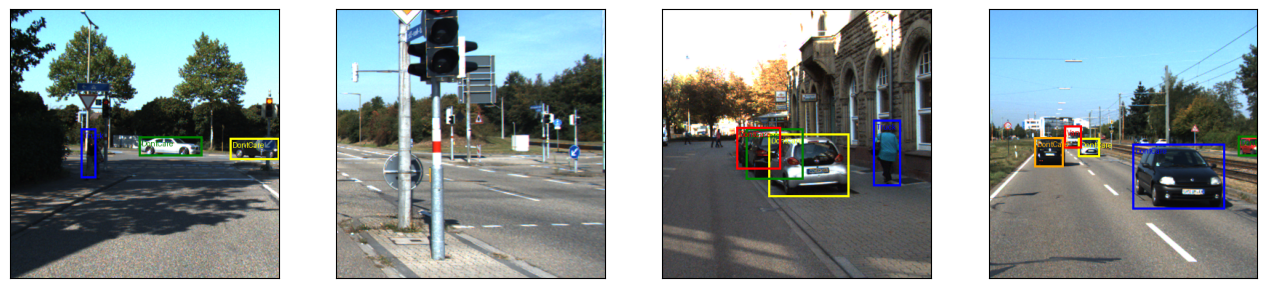

In [ ]:
test_sample = None

for idx, element in enumerate(data_loader):
  if idx == 8:
     test_sample = element
     break

display_samples_h([next(iter(data_loader)) for _ in range(4)])

In [ ]:
model = FastRCNN()
loss_fn = MultiTaskLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.09)

/home/torcsa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
"""
model = model.train()
train_loss = 0.0
sample = test_sample
print(type(sample))
print(sample)
if not torch.numel(sample[1].get('labels')):
    print('SAMPLE DOES NOT HAVE AN OBJECT')
    #print(sample)

img = sample[0]
print('IMAGE:')
print(img)
new_img_shape = (batch_size,) + img.shape
img = img.expand(new_img_shape)
#print(f'Shape of image: {img.shape}')

roi, target_class, target_bbox_corr = generate_training_samples(sample)

#for element in roi:
#  assert not torch.isnan(element).any(), "roi contains NaN values"

#assert not torch.isnan(target_class).any(), "target_class contains NaN values"
#assert not torch.isnan(target_bbox_corr).any(), "target bbox correction contains NaN values"

X = (img, roi)
Y = (target_class, target_bbox_corr)




pred = model(X)


loss = loss_fn(pred, Y)
print(f'The calculated final loss is: {loss}')


# Backpropagation
loss.backward() # TODO backprop after two images?
optimizer.step()
optimizer.zero_grad()


loss = loss.item()
train_loss += loss
print(f'[{epoch + 1:>2}/{epochs}]: train_loss={loss:>5f}  [{idx:>5d}/{num_samples:>5d}]', end='\r')

train_loss /= num_batches
"""

'\nmodel = model.train()\ntrain_loss = 0.0\nsample = test_sample\nprint(type(sample))\nprint(sample)\nif not torch.numel(sample[1].get(\'labels\')):\n    print(\'SAMPLE DOES NOT HAVE AN OBJECT\')\n    #print(sample)\n\nimg = sample[0]\nprint(\'IMAGE:\')\nprint(img)\nnew_img_shape = (batch_size,) + img.shape\nimg = img.expand(new_img_shape)\n#print(f\'Shape of image: {img.shape}\')\n\nroi, target_class, target_bbox_corr = generate_training_samples(sample)\n\n#for element in roi:\n#  assert not torch.isnan(element).any(), "roi contains NaN values"\n\n#assert not torch.isnan(target_class).any(), "target_class contains NaN values"\n#assert not torch.isnan(target_bbox_corr).any(), "target bbox correction contains NaN values"\n\nX = (img, roi)\nY = (target_class, target_bbox_corr)\n\n\n\n\npred = model(X)\n\n\nloss = loss_fn(pred, Y)\nprint(f\'The calculated final loss is: {loss}\')\n\n\n# Backpropagation\nloss.backward() # TODO backprop after two images?\noptimizer.step()\noptimizer.zero_gr

# Test the model

In [ ]:
from sklearn.decomposition import TruncatedSVD

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Truncated SVD

def apply_truncated_svd(layer, rank):
    # Check if the layer is a linear layer
    if isinstance(layer, nn.Linear):
        # Get the weight and bias from the layer
        W = layer.weight.data.cpu().numpy()
        bias = layer.bias.data.cpu().numpy() if layer.bias is not None else None
        
        # Apply Truncated SVD
        svd = TruncatedSVD(n_components=rank)
        W_reduced = svd.fit_transform(W)
        components = svd.components_
        
        # Create new layers with reduced dimensions
        new_layer1 = nn.Linear(W.shape[1], rank, bias=False)
        new_layer2 = nn.Linear(rank, W.shape[0], bias=layer.bias is not None)
        
        # Set the weights of the new layers
        new_layer1.weight.data = torch.tensor(W_reduced, dtype=torch.float32)
        new_layer2.weight.data = torch.tensor(components, dtype=torch.float32)
        
        if layer.bias is not None:
            new_layer2.bias.data = torch.tensor(bias, dtype=torch.float32)
        
        return nn.Sequential(new_layer1, new_layer2)
    else:
        return layer

def apply_svd_to_model(model, rank):
    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            new_module = nn.Sequential(*[apply_truncated_svd(layer, rank) for layer in module])
            setattr(model, name, new_module)
        else:
            new_module = apply_truncated_svd(module, rank)
            setattr(model, name, new_module)


In [ ]:
# TODO


# DONE For Loss classification weight is needed
#       For classes it is already calculated
#       But need to multiply that eith 3/4
#       And weight for Don't care should be 1/3
# DONE -  Since Conv can handle bigger images Dont need rescale 224, 224 transformation
#       Do not need!!
#       But check new dimension
# DONE Put the whole thing on GPU
#
# DONE Validation is needed
#       Validation can be done on the whole image

# DONE - LayerNorm normalization --- NOT Batch normalization 



# Fastening
# Measuring the durations

# Trying out ResNet 50/101

# Do 2 Batches



### For learning


# Data augmentation??? More than that??

# USE RESTNET OR SMTH ELSE INSTEAD OF VGG16

# Setting the parameters for Adam?

# Ensamble learning??

# Weight initilaizing??????

# Learning rate warm up??????


### For testing 

# Scale invarinace - Image pyramids???

# mAP calculation for detection

# Make inference faster with Truncated SVD

# Evaluate
#   Non-maximal supression: 
#       For every object we choose the one from the region proposals that has the highest IoU with the corresponding GT
#
#   Precision:
#       From all of our prediction, how many of them are correct
#       (So from all the predicted bounding boxes, how many has IoU with GT over 0.5)
#
#   Recall:
#       From all the grund truth, how many did we predict correctly
#       
#
#   mAP (mean Average Precision):
#       To say if a predicted bounding box is correct or not
#       Correct if IoU >= 0.5
#       Wring if IoU < 0.5
#
#
#       Look at one class first
#       There are predictions for these classes, and these predictions have a probability
#       Sorting the Bounding boxes based on the probability score
#       Precision - Recall diagram
#       We iterate through the sorted bounding boxes and check if they are correct or not
#
#       The area under the precision - recall diagram is the AP (average precision)
#       
#       We do these calculations for every class
#
#       We take the mean of all these classes and get the mean Average Precision (mAP)
#
#       We redo the calculations with other thresholds (What is the threshold IoU to accept a region proposal)
#
#       And then we take the average of all these numbers